In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import colorsys
import glob

In [20]:
def show(img):
    plt.figure(figsize=(16, 16))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
def show_small(img):
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [21]:
def get_img_paths():
    return glob.glob('pack\\assets\\minecraft\\textures' + '/**/*.png', recursive=True)
def get_textures():
    paths = get_img_paths()
    textures = {}
    for path in paths:
        textures[path] = cv2.imread(path)
    return textures

In [22]:
textures = get_textures()
paths = get_img_paths()
paths

['pack\\assets\\minecraft\\textures\\block\\acacia_door_bottom.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_door_top.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_leaves.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_log.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_log_top.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_planks.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_sapling.png',
 'pack\\assets\\minecraft\\textures\\block\\acacia_trapdoor.png',
 'pack\\assets\\minecraft\\textures\\block\\activator_rail.png',
 'pack\\assets\\minecraft\\textures\\block\\activator_rail_on.png',
 'pack\\assets\\minecraft\\textures\\block\\allium.png',
 'pack\\assets\\minecraft\\textures\\block\\amethyst_block.png',
 'pack\\assets\\minecraft\\textures\\block\\amethyst_cluster.png',
 'pack\\assets\\minecraft\\textures\\block\\ancient_debris_side.png',
 'pack\\assets\\minecraft\\textures\\block\\ancient_debris_top.png',
 'pack\\assets\\min

In [23]:
def get_samples(textures,number):
    blocks = []
    while(True):
        img = textures[paths[random.randint(0,len(textures))]]
        try:
            if img.shape == (16, 16, 3):# and (0,0,0) not in img and (255,255,255) not in img:
                blocks.append(img)
        except:
            pass
        if len(blocks) > number:
            break
    return blocks

<Figure size 432x216 with 0 Axes>

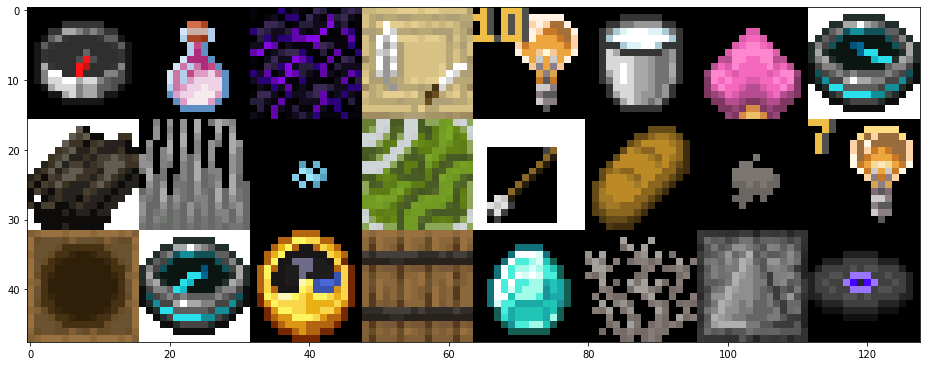

In [580]:
def get_show_line(textures,number):
    blocks = get_samples(textures,number)
    conc = blocks[0]
    for i in blocks[2:]:
        conc = np.concatenate((conc,i),axis=1)
    return conc, blocks
def get_test_img(textures,rows,cols):
    lines = []
    blocks = []
    for i in range(rows):
        line, b = get_show_line(textures,cols)
        lines.append(line)
        for i in b: 
            blocks.append(i)
    conc = lines[0]
    for i in lines[1:]:
        conc = np.concatenate((conc,i),axis=0)
    return conc, blocks
plt_1 = plt.figure(figsize=(6, 3))
mosaic, blocks = get_test_img(textures,3,8)
show(mosaic)

In [25]:
def normalize_channel(matrix):
    short = matrix-np.min(matrix)
    stretched = short * ( 255 / np.max(short) )
    stretched = stretched.astype("uint8")
    return stretched
def normalize(block):
    b = block[:,:,0]
    g = block[:,:,1]
    r = block[:,:,2]
    b_intensity = np.mean(b)
    g_intensity = np.mean(g)
    r_intensity = np.mean(r)
    multiplier = max([b_intensity,g_intensity,r_intensity])
    b = normalize_channel(b)
    g = normalize_channel(g)
    r = normalize_channel(r)
    b = b/multiplier
    g = g/multiplier
    r = r/multiplier
    return (cv2.merge((b,g,r))*multiplier).astype('uint8')

In [26]:
def decrease_depth(image,values):
    image = (image/(255/values)).astype('uint8')
    image = (image*(255/values)).astype('uint8')
    return image

In [546]:
def restore_colors(shallow,block):
    clusters = {}
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            color = shallow[i,j]
            clusters[tuple(color)] = []
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            color = shallow[i,j]
            clusters[tuple(color)].append(block[i][j])
    translate = {}
    for i in clusters.keys():
        if (np.sum(np.median(clusters[i],axis=0).astype('uint8')) == 0):
            translate[i] = (0,0,0)
        else:
            translate[i] = np.mean(clusters[i],axis=0).astype('uint8')
    new = np.zeros(block.shape)
    try:
        translate[tuple([0,0,0])] = translate[sorted(translate.keys())[1]]
    except:
        pass
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            new[i][j] = translate[tuple(shallow[i][j])]
    new = new.astype('uint8')
    return new

In [585]:
def texture_execute(block):
    block = distort_colors(block)
    normalized = normalize(block)
    shallow = decrease_depth(block,3)
    result = restore_colors(shallow,block)
    return result

In [586]:
for path in tqdm(paths):
    try:
        try:
            img = cv2.imread(path)
            alpha = cv2.imread(path, cv2.IMREAD_UNCHANGED)[:,:,3]
            img = texture_execute(img)
            b, g, r = cv2.split(img)
            rgba = [b,g,r, alpha]
            dst = cv2.merge(rgba,4)
            cv2.imwrite(path,dst)   
        except:
            img = cv2.imread(path)
            img = texture_execute(img)
            cv2.imwrite(path,img)   
    except:
        print("failed for ",path)

  3%|▎         | 71/2359 [00:01<01:02, 36.57it/s]C:\Users\Luiz\AppData\Local\Temp\ipykernel_17492\1226521939.py:3: RuntimeWarning: divide by zero encountered in true_divide
  stretched = short * ( 255 / np.max(short) )
C:\Users\Luiz\AppData\Local\Temp\ipykernel_17492\1226521939.py:3: RuntimeWarning: invalid value encountered in multiply
  stretched = short * ( 255 / np.max(short) )
 27%|██▋       | 627/2359 [00:13<00:32, 52.53it/s]C:\Users\Luiz\AppData\Local\Temp\ipykernel_17492\1226521939.py:17: RuntimeWarning: invalid value encountered in true_divide
  b = b/multiplier
C:\Users\Luiz\AppData\Local\Temp\ipykernel_17492\1226521939.py:18: RuntimeWarning: invalid value encountered in true_divide
  g = g/multiplier
C:\Users\Luiz\AppData\Local\Temp\ipykernel_17492\1226521939.py:19: RuntimeWarning: invalid value encountered in true_divide
  r = r/multiplier
100%|██████████| 2359/2359 [04:59<00:00,  7.86it/s]


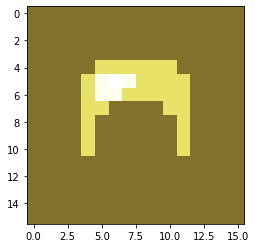

In [545]:
path = 'golden_helmet.png'
img = cv2.imread(path)
alpha = cv2.imread(path, cv2.IMREAD_UNCHANGED)[:,:,3]
img = texture_execute(img)
b, g, r = cv2.split(img)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)
cv2.imwrite(path,dst) 
show_small(dst)

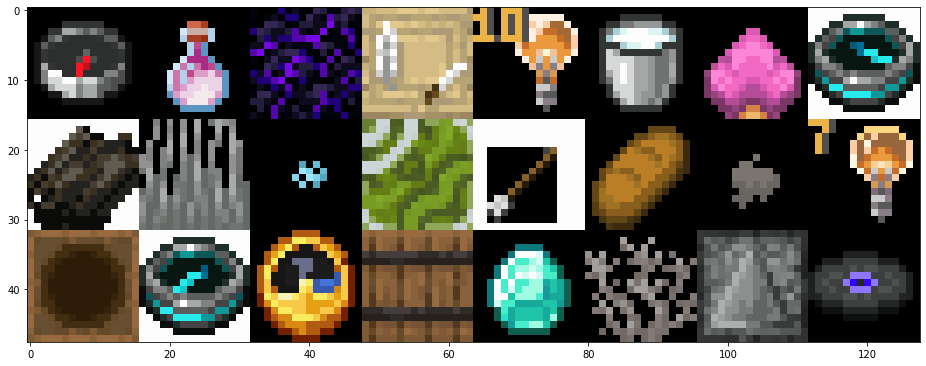

In [581]:
def distort_colors(img,intensity = 2):
    blueish = np.zeros(img.shape).astype('uint8')
    blueish[:,:,1] = int(intensity)
    blueish[:,:,0] = int(intensity)
    #blueish[:,:,2] = intensity*90
    img = cv2.add(img,blueish)
    img = cv2.subtract(img,(np.ones(img.shape)*int(intensity)).astype('uint8'))
    altered = decrease_depth(img,32)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    diff_color = -int(intensity)
    hnew = np.mod(h + diff_color, 180).astype(np.uint8)
    hsv_new = cv2.merge([hnew,s,v])
    bgr_new = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2BGR)

    return bgr_new.astype('uint8')
show(distort_colors(mosaic))

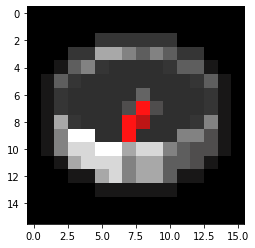

In [582]:
show_small(blocks[0])

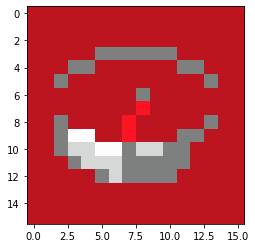

In [583]:
show_small(texture_execute(blocks[0]))